# Initializing Spark 

In [1]:
import os

SCALA_VERSION = '2.12.15'
SPARK_VERISON = '3.2.1'

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.2.1,org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1 pyspark-shell'


In [2]:
#intial spark 
import findspark 
findspark.init()
import pyspark

In [3]:
#Creat Spark session 
from pyspark import SparkContext
from pyspark.streaming import StreamingContext 
from pyspark.sql import SparkSession



spark = SparkSession \
        .builder \
        .appName(" Real-time Outlier detection of human activity Stream based on Phone Accelerometers ")\
        .config('spark.jars.packages','org.apache.spark:spark-sql-kafka-0-10_2.12.15:3.2.1')\
        .config('spark.driver.extraClassPath', 'C:\\Spark\\spark-3.2.1-bin-hadoop3.2\\jars\\spark-iforest-3.0.0_old2.jar')\
        .config("spark.memory","10g")\
        .config("spark.memory.offHeap.enabled","true")\
        .config("spark.memory.offHeap.size","10g")\
        .master("local[*]") \
        .getOrCreate()
          
spark

In [4]:
spark.conf.set("spark.sql.shuffle.partitions",1)


# Reading the dataset of raw data

In [6]:
df = spark.read.option("delimiter", ",").option("header", "false").csv("Real world WISDM_at_latest\\home\\share\\data\\public_sets\\WISDM_at_v2.0\\WISDM_at_v2.0_raw.txt"\
                                                                     ,inferSchema =True)

In [7]:
df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: string (nullable = true)



In [8]:
df.show()

+----+-------+-------------+-----------+----------+------------+
| _c0|    _c1|          _c2|        _c3|       _c4|         _c5|
+----+-------+-------------+-----------+----------+------------+
|1679|Walking|1370520469556|  0.2941316|-0.6356053|-0.22693644;|
|1679|Walking|1370520469606|-0.49968776|-0.6044512|-0.22602014;|
|1679|Walking|1370520469656| -2.1783454| 0.7134906| 0.37201694;|
|1679|Walking|1370520469706| -2.7977629| 1.3548992|-0.27763826;|
|1679|Walking|1370520469756| -2.1679606|-1.3277156| -0.5549711;|
|1679|Walking|1370520469806| -1.7348573| 0.8185594|-0.16554448;|
|1679|Walking|1370520469856| -1.4639386| 0.8359691|  0.4111123;|
|1679|Walking|1370520469906| -0.9450085| 1.0852021| 0.39522982;|
|1679|Walking|1370520469956| 0.18203785|0.28130344|  0.5342017;|
|1679|Walking|1370520470006|  0.9483683|0.07849618|  0.5647449;|
|1679|Walking|1370520470056|  1.6756034|-0.8579602| 0.66889745;|
|1679|Walking|1370520470106|  1.4010195|-1.3286319|  0.4465425;|
|1679|Walking|13705204701

In [9]:
df.describe().show()

+-------+-----------------+-------+--------------------+--------------------+--------------------+--------------+
|summary|              _c0|    _c1|                 _c2|                 _c3|                 _c4|           _c5|
+-------+-----------------+-------+--------------------+--------------------+--------------------+--------------+
|  count|          3005411|2980765|             3005411|             2980765|             2980765|       2980765|
|   mean|1021.751310220133|   null|1.225000504816889...|4.844852613370398E10|  -137368.0428808408|          null|
| stddev|489.7168014267177|   null|3.929292472076259...|8.364585771849433E13|2.3716971823443523E8|          null|
|    min|              194|Jogging|-4889432889458852298|          -46.287388|       -4.0947096E11|-0.0010070801;|
|    max|             1802|Walking|                   ;|       1.44413671E17|            80.13994|     9.999207;|
+-------+-----------------+-------+--------------------+--------------------+-----------

# Main Titled DataFram

In [10]:
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.sql.types import *


 #.withColumnRenamed('_c1','activity')\
dfTitled = df.withColumnRenamed('_c0','deviceID') \
        .withColumnRenamed('_c3','xvalue') \
        .withColumnRenamed("_c4","yvalue") \
        .withColumn('String_zvalue',regexp_replace(col("_c5"), ";",""))\
        .withColumn('zvalue',col("String_zvalue").cast(DoubleType()))\
        .withColumn('timestamp',lit((col("_c2") / 1000).cast(TimestampType())))\
        .drop('_c5')\
        .drop('_c2')\
        .drop('String_zvalue')
        #.drop('_c1')\

        




dfTitled.printSchema()

root
 |-- deviceID: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- xvalue: double (nullable = true)
 |-- yvalue: double (nullable = true)
 |-- zvalue: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



# Training Dataframe Without Lables 

In [11]:
dfTrain = dfTitled.filter((dfTitled._c1 == "Sitting") |
                          (dfTitled._c1 == "Standing") |
                          (dfTitled._c1 == "Stairs") |
                          (dfTitled._c1 == "LyingDown")| 
                          (dfTitled._c1 == "Walking"))
dfTrain.show()

+--------+-------+-----------+----------+-----------+--------------------+
|deviceID|    _c1|     xvalue|    yvalue|     zvalue|           timestamp|
+--------+-------+-----------+----------+-----------+--------------------+
|    1679|Walking|  0.2941316|-0.6356053|-0.22693644|2013-06-06 15:07:...|
|    1679|Walking|-0.49968776|-0.6044512|-0.22602014|2013-06-06 15:07:...|
|    1679|Walking| -2.1783454| 0.7134906| 0.37201694|2013-06-06 15:07:...|
|    1679|Walking| -2.7977629| 1.3548992|-0.27763826|2013-06-06 15:07:...|
|    1679|Walking| -2.1679606|-1.3277156| -0.5549711|2013-06-06 15:07:...|
|    1679|Walking| -1.7348573| 0.8185594|-0.16554448|2013-06-06 15:07:...|
|    1679|Walking| -1.4639386| 0.8359691|  0.4111123|2013-06-06 15:07:...|
|    1679|Walking| -0.9450085| 1.0852021| 0.39522982|2013-06-06 15:07:...|
|    1679|Walking| 0.18203785|0.28130344|  0.5342017|2013-06-06 15:07:...|
|    1679|Walking|  0.9483683|0.07849618|  0.5647449|2013-06-06 15:07:...|
|    1679|Walking|  1.675

In [12]:
dfTrainActivityCount=dfTrain.select(countDistinct("_c1"))
dfTrainActivityCount.show()

+-------------------+
|count(DISTINCT _c1)|
+-------------------+
|                  5|
+-------------------+



In [13]:
dfTrain.count()

2541894

In [14]:
dfTrain = dfTrain.drop('_c1')


In [15]:
dfTrain.show(truncate=False)

+--------+-----------+----------+-----------+-----------------------+
|deviceID|xvalue     |yvalue    |zvalue     |timestamp              |
+--------+-----------+----------+-----------+-----------------------+
|1679    |0.2941316  |-0.6356053|-0.22693644|2013-06-06 15:07:49.556|
|1679    |-0.49968776|-0.6044512|-0.22602014|2013-06-06 15:07:49.606|
|1679    |-2.1783454 |0.7134906 |0.37201694 |2013-06-06 15:07:49.656|
|1679    |-2.7977629 |1.3548992 |-0.27763826|2013-06-06 15:07:49.706|
|1679    |-2.1679606 |-1.3277156|-0.5549711 |2013-06-06 15:07:49.756|
|1679    |-1.7348573 |0.8185594 |-0.16554448|2013-06-06 15:07:49.806|
|1679    |-1.4639386 |0.8359691 |0.4111123  |2013-06-06 15:07:49.856|
|1679    |-0.9450085 |1.0852021 |0.39522982 |2013-06-06 15:07:49.906|
|1679    |0.18203785 |0.28130344|0.5342017  |2013-06-06 15:07:49.956|
|1679    |0.9483683  |0.07849618|0.5647449  |2013-06-06 15:07:50.006|
|1679    |1.6756034  |-0.8579602|0.66889745 |2013-06-06 15:07:50.056|
|1679    |1.4010195 

In [16]:
type(dfTrain)


pyspark.sql.dataframe.DataFrame

In [17]:
dfTrain.describe().show()

+-------+-----------------+--------------------+-------------------+--------------------+
|summary|         deviceID|              xvalue|             yvalue|              zvalue|
+-------+-----------------+--------------------+-------------------+--------------------+
|  count|          2541894|             2541894|            2541894|             2541894|
|   mean|1083.296306218906|5.681341196801971...|-161086.14342222252|2.327036650623517...|
| stddev|501.0467594778724|9.057943135324975E13| 2.56829193911443E8|3.710068613231875...|
|    min|              194|          -46.287388|      -4.0947096E11|           -48.20949|
|    max|             1802|       1.44413671E17|          63.586315|        5.9150805E20|
+-------+-----------------+--------------------+-------------------+--------------------+



In [18]:
dfTrain.filter(dfTrain.yvalue.isNull()).count()

0

In [20]:
dfTrain = dfTrain.na.drop(how="any")

In [21]:
dfTrain.filter(dfTrain.yvalue.isNull()).count()

0

In [22]:
dfTrain.show(1000,truncate=False)

+--------+------------+------------+-------------+-----------------------+
|deviceID|xvalue      |yvalue      |zvalue       |timestamp              |
+--------+------------+------------+-------------+-----------------------+
|1679    |0.2941316   |-0.6356053  |-0.22693644  |2013-06-06 15:07:49.556|
|1679    |-0.49968776 |-0.6044512  |-0.22602014  |2013-06-06 15:07:49.606|
|1679    |-2.1783454  |0.7134906   |0.37201694   |2013-06-06 15:07:49.656|
|1679    |-2.7977629  |1.3548992   |-0.27763826  |2013-06-06 15:07:49.706|
|1679    |-2.1679606  |-1.3277156  |-0.5549711   |2013-06-06 15:07:49.756|
|1679    |-1.7348573  |0.8185594   |-0.16554448  |2013-06-06 15:07:49.806|
|1679    |-1.4639386  |0.8359691   |0.4111123    |2013-06-06 15:07:49.856|
|1679    |-0.9450085  |1.0852021   |0.39522982   |2013-06-06 15:07:49.906|
|1679    |0.18203785  |0.28130344  |0.5342017    |2013-06-06 15:07:49.956|
|1679    |0.9483683   |0.07849618  |0.5647449    |2013-06-06 15:07:50.006|
|1679    |1.6756034   |-0

# features extraction and data transformation 

In [23]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
import pandas as pd
import numpy as np

from scipy import stats
def Max_Min(x,y):
  
  return x-y

Max_Min_udf = F.udf(Max_Min, T.DoubleType())


def absolute_list(x_list):
  
    returnValue = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    return returnValue.item()

absolute_udf = F.udf(absolute_list, T.FloatType())

def median_abs_devu(x_list):
    x = np.array(x_list)
    return stats.median_abs_deviation(x)


spark.udf.register('median_abs_devu',median_abs_devu)



from pyspark.sql.functions import pandas_udf, PandasUDFType
@pandas_udf("double")
def median_abs_dev(v: pd.Series) -> float:
    return stats.median_absolute_deviation(v)

@pandas_udf('float', PandasUDFType.GROUPED_AGG)
def agg_a(x):
    return (x**2).mean()


def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]


C:\Users\MHD\anaconda3\lib\site-packages\pyspark\sql\pandas\functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [24]:
import pyspark.sql.functions as F
@F.udf
def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]

cols = ['ActivityLable']
agg_expr = [mode(F.collect_list(col)).alias(col) for col in cols]



In [25]:
windowedDfTrain = dfTrain \
    .groupBy(window(dfTrain.timestamp, "5 seconds")).agg(\
    mean("xvalue").alias("avg_x"),mean("yvalue").alias("avg_y"),(mean("zvalue").alias("avg_z"))\
    ,stddev("xvalue").alias("std_x"),stddev("yvalue").alias("std_y"),stddev("zvalue").alias("std_z")\
    ,min("xvalue").alias("min_x"),min("yvalue").alias("min_y"),min("zvalue").alias("min_z")\
    ,max("xvalue").alias("max_x"),max("yvalue").alias("max_y"),max("zvalue").alias("max_z")\
    ,Max_Min_udf(max("xvalue"),min("xvalue")).alias("X_maxmin_diff")\
    ,Max_Min_udf(max("yvalue"),min("yvalue")).alias("y_maxmin_diff")\
    ,Max_Min_udf(max("zvalue"),min("zvalue")).alias("z_maxmin_diff")\
    ,skewness("xvalue").alias("skewness_x"),skewness("yvalue").alias("skewness_y"),skewness("zvalue").alias("skewness_z")\
    ,kurtosis("xvalue").alias("kurtosis_x"),kurtosis("yvalue").alias("kurtosis_y"),kurtosis("zvalue").alias("kurtosis_z")\
    ,variance("xvalue").alias("variance_x"),variance("yvalue").alias("variance_y"),variance("zvalue").alias("variance_z")\
    ,F.percentile_approx("Xvalue", 0.5).alias("xmedian"),F.percentile_approx("yvalue", 0.5).alias("ymedian"),F.percentile_approx("zvalue", 0.5).alias("zmedian")\
    ,count(when(col("Xvalue") > 0,1)).alias("PositivX"),count(when(col("Xvalue") < 0,1)).alias("negtiveX")\
    ,count(when(col("yvalue") > 0,1)).alias("Positivy"),count(when(col("yvalue") < 0,1)).alias("negtivey")\
    ,count(when(col("zvalue") > 0,1)).alias("Positivz"),count(when(col("zvalue") < 0,1)).alias("negtivez")\
                                                                )
                                            

In [26]:
from pyspark.sql.functions import when


In [27]:
windowedDfTrain.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- avg_x: double (nullable = true)
 |-- avg_y: double (nullable = true)
 |-- avg_z: double (nullable = true)
 |-- std_x: double (nullable = true)
 |-- std_y: double (nullable = true)
 |-- std_z: double (nullable = true)
 |-- min_x: double (nullable = true)
 |-- min_y: double (nullable = true)
 |-- min_z: double (nullable = true)
 |-- max_x: double (nullable = true)
 |-- max_y: double (nullable = true)
 |-- max_z: double (nullable = true)
 |-- X_maxmin_diff: double (nullable = true)
 |-- y_maxmin_diff: double (nullable = true)
 |-- z_maxmin_diff: double (nullable = true)
 |-- skewness_x: double (nullable = true)
 |-- skewness_y: double (nullable = true)
 |-- skewness_z: double (nullable = true)
 |-- kurtosis_x: double (nullable = true)
 |-- kurtosis_y: double (nullable = true)
 |-- kurtosis_z: double (nullable = true)
 |-- variance_x: double (nullable = t

In [28]:
windowedDfTrain.count()

16289

In [30]:
windowedDfTrain = windowedDfTrain.na.drop(how="any")


In [32]:
windowedDfTrain.count()

Py4JJavaError: An error occurred while calling o378.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 29.0 failed 1 times, most recent failure: Lost task 0.0 in stage 29.0 (TID 48) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:188)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:108)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:121)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:162)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:175)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:188)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:108)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:121)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:162)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:175)
	... 26 more


In [ ]:
# windowedDfTrain.show(1000,truncate=False)

## Isolation Forest 

In [33]:
from pyspark_iforest.ml.iforest import *
iforest = IForest(maxSamples=256,maxDepth=10,contamination=0.05,numTrees=100,maxFeatures=33)



In [34]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [35]:
feat_cols = ['avg_x','avg_y','avg_z',
             'std_x','std_y','std_z',
             'min_x','min_y','min_z',
             'max_x','max_y','max_z',
             'X_maxmin_diff','y_maxmin_diff','z_maxmin_diff',
             'skewness_x','skewness_y','skewness_z',
             'kurtosis_x','kurtosis_y','kurtosis_z',
             'variance_x','variance_y','variance_z',
             'xmedian','ymedian','zmedian',
             'PositivX','negtiveX','Positivy','negtivey','Positivz','negtivez'
                ]

In [36]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features')


In [37]:
final_df_Train = assembler.transform(windowedDfTrain)



In [38]:
iforest_model = iforest.fit(final_df_Train)

# Reading real-time stream Data from Kafka 

In [39]:

RawDf = spark.readStream\
        .format("kafka")\
        .option("kafka.bootstrap.servers", "localhost:9092")\
        .option("subscribe", "messages")\
        .option("startingOffsets", "latest")\
        .load()


In [40]:
print("Streaming DataFrame : " + str(RawDf.isStreaming))


Streaming DataFrame : True


In [41]:
print("Printing Schema of MainDf: ")

RawDf.printSchema()

Printing Schema of MainDf: 
root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [42]:
display(RawDf)

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

In [43]:
# Define a schema for the MainDf data
# X_Value,Y_Value,Z_Value,TimeStamp_Value
from pyspark.sql.functions import *
from pyspark.sql.types import *

import time
Spark_schema = RawDf.selectExpr("CAST(value AS STRING)")
#Spark_schema = RawDf.selectExpr("CAST(value AS STRING)","timestamp")

print("Printing Schema of Spark_schema: ")

Spark_schema.printSchema()

Printing Schema of Spark_schema: 
root
 |-- value: string (nullable = true)



In [46]:

My_schema = StructType() \
        .add("xvalue", DoubleType()) \
        .add("yvalue", DoubleType()) \
        .add("zvalue", DoubleType()) \
        .add("deviceID", StringType())\
        .add("timestamp", StringType())\
        .add("label", DoubleType()) 



In [47]:
orders_df2 = Spark_schema\
        .select(from_json(col("value"), My_schema)\
        .alias("records"))
       # .alias("records"),"timestamp")

orders_df3 = orders_df2.select("records.*")


orders_df4=orders_df3.withColumn('timestamp2',lit((col("timestamp") / 1000).cast(TimestampType())))\
                    .drop('timestamp')\
                    .withColumnRenamed('timestamp2','timestamp')


In [50]:
display(orders_df4)

DataFrame[xvalue: double, yvalue: double, zvalue: double, deviceID: string, label: double, timestamp: timestamp]

### 

In [51]:
orders_df4.printSchema()


root
 |-- xvalue: double (nullable = true)
 |-- yvalue: double (nullable = true)
 |-- zvalue: double (nullable = true)
 |-- deviceID: string (nullable = true)
 |-- label: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [52]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
import pandas as pd
import numpy as np

from scipy import stats
def Max_Min(x,y):
  
  return x-y

Max_Min_udf = F.udf(Max_Min, T.DoubleType())


def absolute_list(x_list):
  
    returnValue = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    return returnValue.item()

absolute_udf = F.udf(absolute_list, T.FloatType())

def median_abs_devu(x_list):
    x = np.array(x_list)
    return stats.median_abs_deviation(x)


spark.udf.register('median_abs_devu',median_abs_devu)



from pyspark.sql.functions import pandas_udf, PandasUDFType
@pandas_udf("double")
def median_abs_dev(v: pd.Series) -> float:
    return stats.median_absolute_deviation(v)

@pandas_udf('float', PandasUDFType.GROUPED_AGG)
def agg_a(x):
    return (x**2).mean()


def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]


In [53]:
import pyspark.sql.functions as F
@F.udf
def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]

cols = ['label']
agg_expr = [mode(F.collect_list(col)).alias(col) for col in cols]



In [54]:
windowedCountsDF = orders_df4 \
    .withWatermark("timestamp", "5 seconds").groupBy(window("timestamp", "5 seconds")).agg(\
    mean("xvalue").alias("avg_x"),mean("yvalue").alias("avg_y"),(mean("zvalue").alias("avg_z"))\
    ,stddev("xvalue").alias("std_x"),stddev("yvalue").alias("std_y"),stddev("zvalue").alias("std_z")\
    ,min("xvalue").alias("min_x"),min("yvalue").alias("min_y"),min("zvalue").alias("min_z")\
    ,max("xvalue").alias("max_x"),max("yvalue").alias("max_y"),max("zvalue").alias("max_z")\
    ,Max_Min_udf(max("xvalue"),min("xvalue")).alias("X_maxmin_diff")\
    ,Max_Min_udf(max("yvalue"),min("yvalue")).alias("y_maxmin_diff")\
    ,Max_Min_udf(max("zvalue"),min("zvalue")).alias("z_maxmin_diff")\
    ,skewness("xvalue").alias("skewness_x"),skewness("yvalue").alias("skewness_y"),skewness("zvalue").alias("skewness_z")\
    ,kurtosis("xvalue").alias("kurtosis_x"),kurtosis("yvalue").alias("kurtosis_y"),kurtosis("zvalue").alias("kurtosis_z")\
    ,variance("xvalue").alias("variance_x"),variance("yvalue").alias("variance_y"),variance("zvalue").alias("variance_z")\
    ,F.percentile_approx("Xvalue", 0.5).alias("xmedian"),F.percentile_approx("yvalue", 0.5).alias("ymedian"),F.percentile_approx("zvalue", 0.5).alias("zmedian")\
    ,count(when(col("Xvalue") > 0,1)).alias("PositivX"),count(when(col("Xvalue") < 0,1)).alias("negtiveX")\
    ,count(when(col("yvalue") > 0,1)).alias("Positivy"),count(when(col("yvalue") < 0,1)).alias("negtivey")\
    ,count(when(col("zvalue") > 0,1)).alias("Positivz"),count(when(col("zvalue") < 0,1)).alias("negtivez")\
    ,*agg_expr\
    #,stats.median_abs_deviation(collect_set("xvalue"))\
    #,median_abs_dev(dff["zvalue"])
                                                                )

In [59]:
windowedCountsDF.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- avg_x: double (nullable = true)
 |-- avg_y: double (nullable = true)
 |-- avg_z: double (nullable = true)
 |-- std_x: double (nullable = true)
 |-- std_y: double (nullable = true)
 |-- std_z: double (nullable = true)
 |-- min_x: double (nullable = true)
 |-- min_y: double (nullable = true)
 |-- min_z: double (nullable = true)
 |-- max_x: double (nullable = true)
 |-- max_y: double (nullable = true)
 |-- max_z: double (nullable = true)
 |-- X_maxmin_diff: double (nullable = true)
 |-- y_maxmin_diff: double (nullable = true)
 |-- z_maxmin_diff: double (nullable = true)
 |-- skewness_x: double (nullable = true)
 |-- skewness_y: double (nullable = true)
 |-- skewness_z: double (nullable = true)
 |-- kurtosis_x: double (nullable = true)
 |-- kurtosis_y: double (nullable = true)
 |-- kurtosis_z: double (nullable = true)
 |-- variance_x: double (nullable = t

In [60]:
display(windowedCountsDF)

DataFrame[window: struct<start:timestamp,end:timestamp>, avg_x: double, avg_y: double, avg_z: double, std_x: double, std_y: double, std_z: double, min_x: double, min_y: double, min_z: double, max_x: double, max_y: double, max_z: double, X_maxmin_diff: double, y_maxmin_diff: double, z_maxmin_diff: double, skewness_x: double, skewness_y: double, skewness_z: double, kurtosis_x: double, kurtosis_y: double, kurtosis_z: double, variance_x: double, variance_y: double, variance_z: double, xmedian: double, ymedian: double, zmedian: double, PositivX: bigint, negtiveX: bigint, Positivy: bigint, negtivey: bigint, Positivz: bigint, negtivez: bigint, label: string]

In [61]:
assembler2 = VectorAssembler(inputCols=feat_cols, outputCol='features')


In [62]:
windowedCountsDF2 = assembler2.setHandleInvalid("skip").transform(windowedCountsDF)

In [64]:
display(windowedCountsDF2)

DataFrame[window: struct<start:timestamp,end:timestamp>, avg_x: double, avg_y: double, avg_z: double, std_x: double, std_y: double, std_z: double, min_x: double, min_y: double, min_z: double, max_x: double, max_y: double, max_z: double, X_maxmin_diff: double, y_maxmin_diff: double, z_maxmin_diff: double, skewness_x: double, skewness_y: double, skewness_z: double, kurtosis_x: double, kurtosis_y: double, kurtosis_z: double, variance_x: double, variance_y: double, variance_z: double, xmedian: double, ymedian: double, zmedian: double, PositivX: bigint, negtiveX: bigint, Positivy: bigint, negtivey: bigint, Positivz: bigint, negtivez: bigint, label: string, features: vector]

In [65]:
from pyspark.sql import functions as F
def foreach_batch_function(df,epoch_id):
    df.cache()
    newdf = iforest_model.transform(df)
    
    pred_value=newdf.select(col("window").cast("string"),'anomalyScore','prediction','label')\
    .selectExpr("CAST(to_json(struct(*)) AS STRING) AS value")

    
    pred_value.write\
               .format("kafka")\
               .option("kafka.bootstrap.servers", "localhost:9092")\
               .option("topic", "result")\
               .save()
    df.unpersist()
    
  


    

In [66]:
test= windowedCountsDF2.writeStream \
                .foreachBatch(foreach_batch_function)\
                .trigger(processingTime='5 seconds')\
                .outputMode("append")\
                .option("truncate", "False")  \
                .start()


# Evaluation with Streaming Data


In [14]:
dfEval = spark.read.option("delimiter", ",").option("header", "true").csv("C:full.csv"\
                                                             ,inferSchema =True)

In [15]:
dfEval.printSchema()


root
 |-- window: string (nullable = true)
 |-- anomalyScore: double (nullable = true)
 |-- prediction: integer (nullable = true)
 |-- label: integer (nullable = true)



In [16]:
from pyspark.sql.functions import col

dfEval2 = dfEval.withColumn("prediction2",col("prediction").cast('double'))\
                .withColumn("label2",col("Label").cast('double'))\
                .drop('Label')\
                .drop('prediction')\
                .withColumnRenamed("Label2","Label") \
                .withColumnRenamed("prediction2","prediction")


In [17]:
dfEval2.printSchema()

root
 |-- window: string (nullable = true)
 |-- anomalyScore: double (nullable = true)
 |-- prediction: double (nullable = true)
 |-- Label: double (nullable = true)



In [18]:
dfEval2.show(truncate=False)

+------------------------------------------+------------+----------+-----+
|window                                    |anomalyScore|prediction|Label|
+------------------------------------------+------------+----------+-----+
|{2023-02-07 01:57:00, 2023-02-07 01:57:05}|0.431315262 |0.0       |0.0  |
|{2023-02-07 01:57:05, 2023-02-07 01:57:10}|0.449136957 |0.0       |0.0  |
|{2023-02-07 01:57:30, 2023-02-07 01:57:35}|0.429138983 |0.0       |0.0  |
|{2023-02-07 01:57:35, 2023-02-07 01:57:40}|0.42206722  |0.0       |0.0  |
|{2023-02-07 01:57:40, 2023-02-07 01:57:45}|0.420118932 |0.0       |0.0  |
|{2023-02-07 01:57:45, 2023-02-07 01:57:50}|0.418661365 |0.0       |0.0  |
|{2023-02-07 01:57:50, 2023-02-07 01:57:55}|0.420484302 |0.0       |0.0  |
|{2023-02-07 01:57:55, 2023-02-07 01:58:00}|0.412326656 |0.0       |0.0  |
|{2023-02-07 01:58:00, 2023-02-07 01:58:05}|0.423684019 |0.0       |0.0  |
|{2023-02-07 01:58:05, 2023-02-07 01:58:10}|0.430831331 |0.0       |0.0  |
|{2023-02-07 01:58:10, 20

In [19]:

# Predict for a new data frame based on the fitted model
scoreAndLabels = dfEval2

In [24]:
scoreAndLabels.printSchema()


root
 |-- window: string (nullable = true)
 |-- anomalyScore: double (nullable = true)
 |-- prediction: double (nullable = true)
 |-- Label: double (nullable = true)



In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

predictionAndTarget = scoreAndLabels.select('Label','prediction').rdd

predictionAndTargetNumpy = np.array((predictionAndTarget.collect()))



In [29]:

print ('Accuracy:', accuracy_score(predictionAndTargetNumpy[:,0],predictionAndTargetNumpy[:,1]))
print ('F1 score:', f1_score(predictionAndTargetNumpy[:,0],predictionAndTargetNumpy[:,1]))
print ('Recall:', recall_score(predictionAndTargetNumpy[:,0],predictionAndTargetNumpy[:,1]))
print ('Precision:', precision_score(predictionAndTargetNumpy[:,0],predictionAndTargetNumpy[:,1]))
print ('\n clasification report:\n', classification_report(predictionAndTargetNumpy[:,0],predictionAndTargetNumpy[:,1]))



Accuracy: 0.9745222929936306
F1 score: 0.9130434782608695
Recall: 0.8842105263157894
Precision: 0.9438202247191011

 clasification report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       533
         1.0       0.94      0.88      0.91        95

    accuracy                           0.97       628
   macro avg       0.96      0.94      0.95       628
weighted avg       0.97      0.97      0.97       628



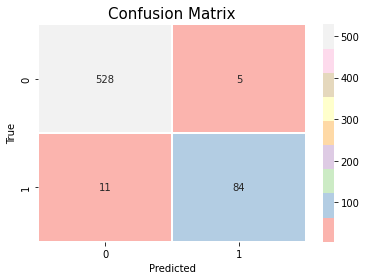

In [30]:
cm = confusion_matrix(predictionAndTargetNumpy[:,0],predictionAndTargetNumpy[:,1])

sns.heatmap(cm,annot=True,cmap='Pastel1',linewidths=2,fmt='d')
plt.title("Confusion Matrix",fontsize=15)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()